In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#california housing dataset
from sklearn.datasets import fetch_california_housing

In [ ]:
#load the houseing datasset
housing = fetch_california_housing()
X = housing.data
y = housing.target

y = y.reshape((len(y), 1))
#prints the name of features
print("Features used to regress the price of the house: ", housing.feature_names)
#All are numeric values and hence we can use all the features after normalization
print(X.shape)
print(y.shape)
print(np.max(X, axis=0))

Features used to regress the price of the house:  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
(20640, 8)
(20640, 1)
[ 1.50001000e+01  5.20000000e+01  1.41909091e+02  3.40666667e+01
  3.56820000e+04  1.24333333e+03  4.19500000e+01 -1.14310000e+02]


In [ ]:
#transforms each feature into 0 mean and s.d of 1
def Normalize_features(X, ax):
  #finds mean of each feature (treating each feature to be independent of the others)
  mu = np.mean(X, axis = ax, keepdims=True)
  print(mu.shape)
  std = np.std(X, axis=ax, keepdims=True)
  X_new = (X-mu)/std
  return X_new

X_t = Normalize_features(X, 0)
#sanity check
print("The mean and variance after preprocessing")
print("Mean of the features:", np.mean(X_t, axis=0))
print("Standard deviation: ", np.std(X_t, axis=0))

print("Range of y: ",np.min(y), np.max(y))

(1, 8)
The mean and variance after preprocessing
Mean of the features: [ 6.60969987e-17  5.50808322e-18  6.60969987e-17 -1.06030602e-16
 -1.10161664e-17  3.44255201e-18 -1.07958431e-15 -8.52651283e-15]
Standard deviation:  [1. 1. 1. 1. 1. 1. 1. 1.]
Range of y:  0.14999 5.00001


In [ ]:
##THE DNN module
#(X_t, y) is here to train the neural network now
#according to our notation psi is the activation function

class MLP:
    def __init__(self, X_train, y_train, arch_details):
        self.X_train = X_train
        self.y_train = y_train
        self.parameters = {}
        #architechture details has the information regarding number of layers (length of the array), and number of units
        self.arch_details = arch_details
        self.initialize_weights()

    def initialize_weights(self):
        for i in range(1, len(self.arch_details)):
            #since all the data is in 0 mean std 1 distribution, rescaling the weight by multiplying with a fraction
            self.parameters["W_"+str(i)] = np.random.normal(0, 0.01, size=(self.arch_details[i], self.arch_details[i-1]))
            self.parameters["b_"+str(i)] = np.zeros((self.arch_details[i], 1))

    def relu(self, V):
        #only using ReLU activation functions (as all the targets are positive), throughout
        #Relu(x) = max(0, x)
        return np.maximum(V, 0)

    def d_relu(self, V):
        #the gradeint is d_psi/dV
        #1E-9 is for numerical stability
        return np.maximum(V/(np.abs(V)+1E-9), 0)


    def MSE_cost(self, Z_L, y):
        #Z_l and y are row vectors (squared error divided by the number of examples)
        e_L =  (Z_L - y)  #error
        return np.squeeze((e_L.dot(e_L.T))/(y.shape[1]))

    def d_MSE_cost(self, Z_L, y):
        #derivative of the cost with respect to Z_L is the error itself
        return 2*(Z_L - y)  #error (a vector)

    #helper function will pass batches and not the entire data
    def forward_prop(self, X_b):
        outputs = {}
        outputs["Z_0"] = X_b
        for i in range(1, len(self.arch_details)):
            #V_i = W_i Z_{i-1} + b_i
            outputs["V_"+str(i)] = self.parameters["W_"+str(i)].dot(outputs["Z_"+str(i-1)]) + self.parameters["b_"+str(i)]
            #relu is the activation function
            outputs["Z_"+str(i)] = self.relu(outputs["V_"+str(i)])
        return outputs

    def back_prop(self, X_b, y_b):
        gradients = {}
        #get results of forward prop: useful for backprop
        outputs = self.forward_prop(X_b)
        #del = Z*d_relu(V)
        #base case
        gradients["dZ_"+str(len(self.arch_details)-1)] = self.d_MSE_cost(outputs["Z_"+str(len(self.arch_details)-1)], y_b)
        for i in range(len(self.arch_details)-1, 0, -1):
            gradients["del_"+str(i)] = gradients["dZ_"+str(i)]*self.d_relu(outputs["V_"+str(i)])
            gradients["dW_"+str(i)] = gradients["del_"+str(i)].dot(outputs["Z_"+str(i-1)].T)/X_b.shape[1]
            #sum of columns
            gradients["db_"+str(i)] = np.sum(gradients["del_"+str(i)], axis=1, keepdims=True)/X_b.shape[1]
            #print(i)
            gradients["dZ_"+str(i-1)] = self.parameters["W_"+str(i)].T.dot(gradients["del_"+str(i)])

        return gradients

    def get_batch(self, bs):
        #choose bs random indices
        chosen = np.random.choice(self.X_train.shape[1], bs, replace=False)
        return self.X_train[:, chosen], self.y_train[:, chosen]

    def grad_descent(self, bs, lr, epochs):
        cost = []
        #1 epoch is 1 traversal through the training data
        epoch_l = int(self.X_train.shape[1]/bs)
        for i in range(epochs):
            outputs = self.forward_prop(self.X_train)
            cost_ith_ep = self.MSE_cost(outputs["Z_"+str(len(self.arch_details)-1)], self.y_train)
            cost.append(cost_ith_ep)
            if i%5==0:
                #print cost after every 5 epochs
                print("Cost after epoch "+str(i)+": "+str(cost[-1]))
            for itr in range(epoch_l):
                X_b, y_b = self.get_batch(bs)
                gradients = self.back_prop(X_b, y_b)
                #update the weights
                for j in range(1, len(self.arch_details)):
                    self.parameters["W_"+str(j)] = self.parameters["W_"+str(j)] - lr*gradients["dW_"+str(j)]
                    self.parameters["b_"+str(j)] = self.parameters["b_"+str(j)] - lr*gradients["db_"+str(j)]
        return cost

In [ ]:
#plot functions
def plot_curve1(pts, x_label, y_label, title):
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  index = np.arange(1, len(pts)+1, 1)
  plt.plot(index, pts, '-b')

  plt.show()

def plot_curve2(pts1, pts2, x_label, y_label, title, legend):
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  index = np.arange(1, len(pts1)+1, 1)
  plt.plot(index, pts1, '-b', label=legend[0])
  plt.plot(index, pts2, '-r', label=legend[1])

  plt.legend()
  plt.show()

(8, 20640)
W_1:  (32, 8)
b_1:  (32, 1)
W_2:  (16, 32)
b_2:  (16, 1)
W_3:  (1, 16)
b_3:  (1, 1)
Cost after epoch 0: 5.6104770281048095
Cost after epoch 5: 1.502678439139601
Cost after epoch 10: 1.3387661717180852
Cost after epoch 15: 1.3319923704164358
Cost after epoch 20: 1.3314616529497583
Cost after epoch 25: 1.3314221508086799
Cost after epoch 30: 1.3314102004151418
Cost after epoch 35: 1.3313611197289397


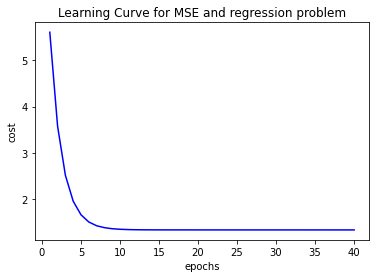

In [ ]:
#example MLP
#checking the functions
arch_details = [8, 32, 16, 1]
X_train = X_t.T
print(X_train.shape)
y_train = y.T
#instantiate the model
mlp_model = MLP(X_train, y_train, arch_details)

for i in range(1, 4):
  print("W_"+str(i)+": ", mlp_model.parameters["W_"+str(i)].shape)
  print("b_"+str(i)+": ", mlp_model.parameters["b_"+str(i)].shape)

bs=128
lr = 0.001
cost = mlp_model.grad_descent(bs, lr, 40)
plot_curve1(cost, "epochs", "cost", "Learning Curve for MSE and regression problem")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 8)]               0         
                                                                 
 layer1 (Dense)              (None, 32)                288       
                                                                 
 layer2 (Dense)              (None, 16)                528       
                                                                 
 layer3 (Dense)              (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
162/162 [==============================] - 0s 869us/step - loss: 4.5005 - mse: 4.5005
Epoch 2/40
162/162 [==============================] - 0s 755us/step - loss: 2.9856 - mse: 2.9856
E

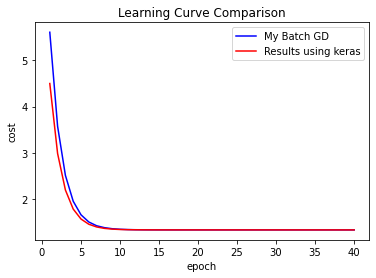

In [ ]:
#testing with inbuilt library
#comparing with Keras library:
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input = Input(shape=X_t.shape[1], name='Input')
Z = Dense(arch_details[1], activation='ReLU', kernel_initializer=initializers.RandomNormal(stddev=0.01), name='layer1')(input)
Z = Dense(arch_details[2], activation='ReLU', kernel_initializer=initializers.RandomNormal(stddev=0.01), name='layer2')(Z)
output = Dense(arch_details[3], activation='ReLU', kernel_initializer=initializers.RandomNormal(stddev=0.01), name='layer3')(Z)
model = Model(inputs=input, outputs=output)
#model description
model.summary()
#we have defined mse error

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss='mse', metrics=['mse'])
history = model.fit(X_t, y, batch_size=bs, epochs=40)
plot_curve2(cost, history.history['mse'], "epoch", "cost", "Learning Curve Comparison", ["My Batch GD", "Results using keras"])